## parallax fit using [MulensModel](https://github.com/rpoleski/MulensModel) and [PyMultiNest](https://github.com/JohannesBuchner/PyMultiNest)
- adapted from https://github.com/rpoleski/MulensModel/blob/master/examples/example_07_fit_parallax_MN.py

In [1]:
import numpy as np
from pymultinest.solve import solve
from pymultinest.analyse import Analyzer
import matplotlib.pyplot as plt 
import MulensModel as mm
import corner
import pandas as pd 

In [2]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
plt.rcParams["figure.figsize"] = (12,6)
from matplotlib import rc
rc('text', usetex=False)

### fetch example data

In [3]:
from pathlib import Path 
file_name = Path("~/repos/MulensModel/data").expanduser()/Path("photometry_files/OB05086/starBLG234.6.I.218982.dat") # path for mulensmodel data
data = mm.MulensData(file_name=file_name, add_2450000=True)

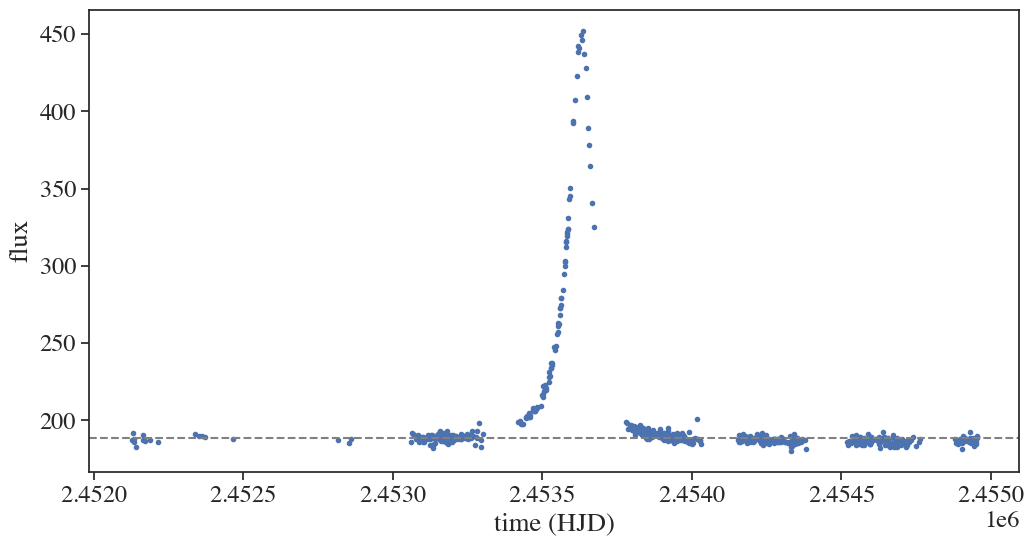

In [15]:
plt.xlabel("time (HJD)")
plt.ylabel("flux")
plt.plot(data.time, data.flux, '.')
plt.axhline(y=np.median(data.flux), c='gray', ls='dashed');

### optimization

In [5]:
from scipy.special import erfinv

class Optim(object):
    """
    A class used to store settings and functions that are used and
    called by MultiNest.

    Parameters :
        event: *MulensModel.event*
            Event for which log-likelihood will be calculated.

        parameters_to_fit: *list*
            Names of parameters to be fitted, e.g.,  ["t_0", "u_0", "t_E"]
    """
    def __init__(self, event, parameters_to_fit):
        self.event = event
        self.parameters_to_fit = parameters_to_fit

    def set_prior_params(self, values_1, values_2, prior_type):
        """set priors
        
            Args:
                prior_type: list, 0: uniform, 1: log-uniform, 2: Gaussian
                values_1: list, lower limit (uniform or log-uniform); mean for gaussian
                values_2: list, upper limit (uniform or log-uniform); sigma for gaussian
        
        """
        self._values_1 = values_1
        self._values_2 = values_2
        self._differences = values_2 - values_1
        self._logdifferences = np.log(values_2/values_1)
        self._prior_type = prior_type

    def prior(self, cube):
        """conversion from [0,1] cube (for MultiNest)
        """
        ret = self._values_1 + self._differences * cube
        idx_log, idx_normal = self._prior_type==1, self._prior_type==2
        if np.sum(idx_log):
            ret[idx_log] = (self._values_1 * np.exp(cube*self._logdifferences))[idx_log]
        if np.sum(idx_normal):
            ret[idx_normal] = (self._values_1 + 2*self._values_2*erfinv(2*cube-1))[idx_normal]
        return ret
    
    def get_model(self, t, theta, fitF):
        for (i, param) in enumerate(self.parameters_to_fit):
            setattr(self.event.model.parameters, param, theta[i])
        
        magnification = self.event.model.get_magnification(time=t)
        if fitF:
            ftot, fblend_frac = theta[len(self.parameters_to_fit):len(self.parameters_to_fit)+2] # Fs+Fb, Fb/(Fs+Fb)
            fs, fb = (1. - fblend_frac) * ftot, fblend_frac * ftot
        else:
            y = self.event.datasets[0].flux
            mag_data = self.event.model.get_magnification(time=self.event.datasets[0].time)
            A = np.array([mag_data, np.ones_like(y)]).T
            fs, fb = np.linalg.lstsq(A, y)[0]

        flux_model = fs * magnification + fb

        return flux_model

    def loglikelihood(self, theta):
        t, f, ferr = self.event.datasets[0].time, self.event.datasets[0].flux, self.event.datasets[0].err_flux
        flux_model = self.get_model(t, theta, fitF=True)
        residual = f - flux_model
        return -0.5 * np.sum((residual / ferr)**2)

In [6]:
coords = "18:04:45.71 -26:59:15.2"
event_name = 'OGLE-2005-BLG-086'
t_0_init = 2453628.
params = {'t_0': t_0_init, 't_0_par': t_0_init, 'u_0': 0.37, 't_E': 100.,
          'pi_E_N': 0., 'pi_E_E': 0.}


In [7]:
median_flux = np.median(data.flux) # guess for Fs+Fb
parameters_to_fit = ["t_0", "u_0", "t_E", "pi_E_N", "pi_E_E"]
min_values = np.array([t_0_init-100, -1, 1., -0.5, -0.5] + [median_flux*0.5, 0])
max_values = np.array([t_0_init+100, 1, 1e3, 0.5, 0.5] + [median_flux*1.5, 1.])
prior_type = np.array([0, 0, 1, 0, 0, 0, 0]) # 0: uniform, 1: log-uniform
wrapped = prior_type * 0 # True for angles

In [8]:
model = mm.Model(params, coords=coords)
event = mm.Event(datasets=data, model=model)

In [9]:
optim = Optim(event, parameters_to_fit)
optim.set_prior_params(min_values, max_values, prior_type)

/var/folders/qp/91qlh0v11sb02z6vb4nb_s0m0000gn/T/ipykernel_11097/502189061.py:31: RuntimeWarning: divide by zero encountered in divide
  self._logdifferences = np.log(values_2/values_1)
/var/folders/qp/91qlh0v11sb02z6vb4nb_s0m0000gn/T/ipykernel_11097/502189061.py:31: RuntimeWarning: invalid value encountered in log
  self._logdifferences = np.log(values_2/values_1)


In [10]:
n_live_points = 1000 # may want to start from a smaller value for testing
output_dir = "parallax_fit"
run_kwargs = {
    'LogLikelihood': optim.loglikelihood,
    'const_efficiency_mode': False,
    'Prior': optim.prior,
    'n_dims': len(prior_type),
    'outputfiles_basename': str(Path(f"{output_dir}/lp{n_live_points}_")),
    'resume': False, 
    'n_live_points': n_live_points,
    'wrapped_params': list(wrapped),
    'sampling_efficiency': 0.03,
    'importance_nested_sampling': False,
    'multimodal': True
    }

In [11]:
# ~5min for n_live_points = 1000
result = solve(**run_kwargs)

/var/folders/qp/91qlh0v11sb02z6vb4nb_s0m0000gn/T/ipykernel_11097/502189061.py:40: RuntimeWarning: invalid value encountered in multiply
  ret[idx_log] = (self._values_1 * np.exp(cube*self._logdifferences))[idx_log]


 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    7
 *****************************************************
  analysing data from parallax_fit/lp1000_.txt ln(ev)=  -508.03626690761877      +/-  0.18011954199293712     
 Total Likelihood Evaluations:       873307
 Sampling finished. Exiting MultiNest



In [12]:
#%% Analyze results - we print each mode separately and give log-evidence:
analyzer = Analyzer(n_params=run_kwargs['n_dims'],
                    outputfiles_basename=run_kwargs['outputfiles_basename'])
modes = analyzer.get_mode_stats()['modes']
for mode in modes:
    print("\nMode {:} parameters:".format(mode['index']))
    for (p, m, s) in zip(parameters_to_fit, mode['mean'], mode['sigma']):
        print("{:6} = {:.4f} +- {:.4f}".format(p, m, s))
    print("local log-evidence: {:.3f} +- {:.3f}".format(
            mode["local log-evidence"], mode["local log-evidence error"]))

  analysing data from parallax_fit/lp1000_.txt

Mode 0 parameters:
t_0    = 2453630.0450 +- 0.1952
u_0    = 0.4392 +- 0.0047
t_E    = 97.1319 +- 1.7741
pi_E_N = 0.2080 +- 0.0304
pi_E_E = 0.0902 +- 0.0053
local log-evidence: -514.676 +- 0.185

Mode 1 parameters:
t_0    = 2453630.6970 +- 0.2760
u_0    = -0.4156 +- 0.0126
t_E    = 110.4480 +- 3.5944
pi_E_N = -0.2985 +- 0.0272
pi_E_E = 0.1108 +- 0.0079
local log-evidence: -508.038 +- 0.180


<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
/var/folders/qp/91qlh0v11sb02z6vb4nb_s0m0000gn/T/ipykernel_11097/666036981.py:2: SyntaxWarning: invalid escape sequence '\m'
  labels = ['$t_0$', '$u_0$', '$t_\mathrm{E}$', '$\pi_\mathrm{E,N}$', '$\pi_\mathrm{E,E}$', '$F_\mathrm{s}+F_\mathrm{b}$', '$F_\mathrm{b}/(F_\mathrm{s}+F_\mathrm{b})$']
/var/folders/qp/91qlh0v11sb02z6vb4nb_s0m0000gn/T/ipykernel_11097/666036981.py:2: SyntaxWarning: invalid escape sequence '\p'
  labels = ['$t_0$', '$u_0$', '$t_\mathrm{E}$', '$\pi_\mathrm{E,N}$', '$\pi_\math

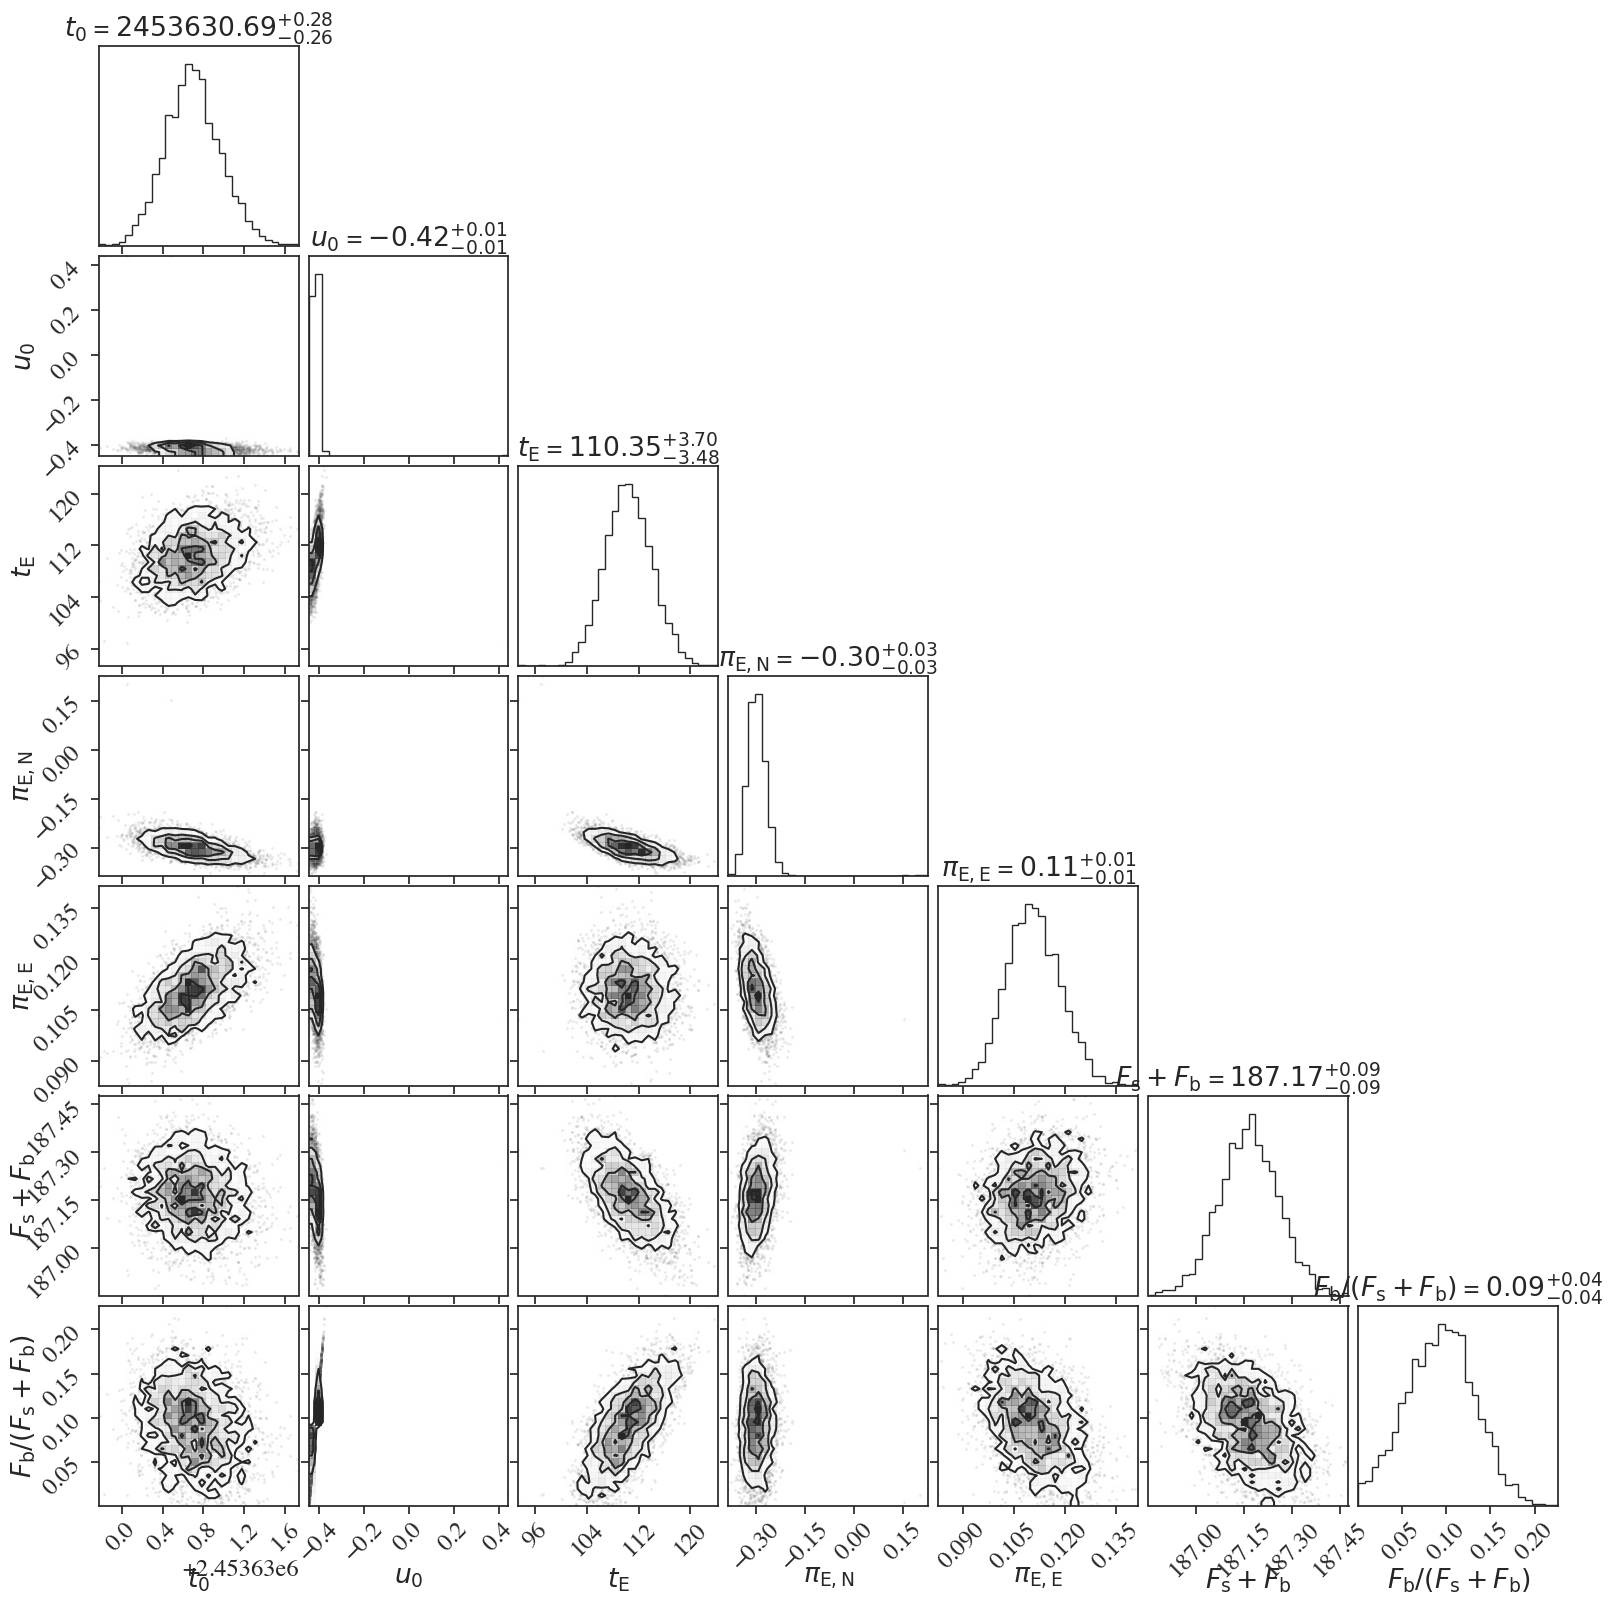

In [17]:
samples = analyzer.get_equal_weighted_posterior()[:,:-1] # last column is log-likelihood
labels = ['$t_0$', '$u_0$', '$t_\mathrm{E}$', '$\pi_\mathrm{E,N}$', '$\pi_\mathrm{E,E}$', '$F_\mathrm{s}+F_\mathrm{b}$', '$F_\mathrm{b}/(F_\mathrm{s}+F_\mathrm{b})$']
fig = corner.corner(samples, labels=labels, show_titles=True, bins=30)
plt.savefig(run_kwargs['outputfiles_basename']+"corner.png", dpi=200, bbox_inches="tight")

/var/folders/qp/91qlh0v11sb02z6vb4nb_s0m0000gn/T/ipykernel_11097/502189061.py:57: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  fs, fb = np.linalg.lstsq(A, y)[0]
/var/folders/qp/91qlh0v11sb02z6vb4nb_s0m0000gn/T/ipykernel_11097/3064908991.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=0.02)


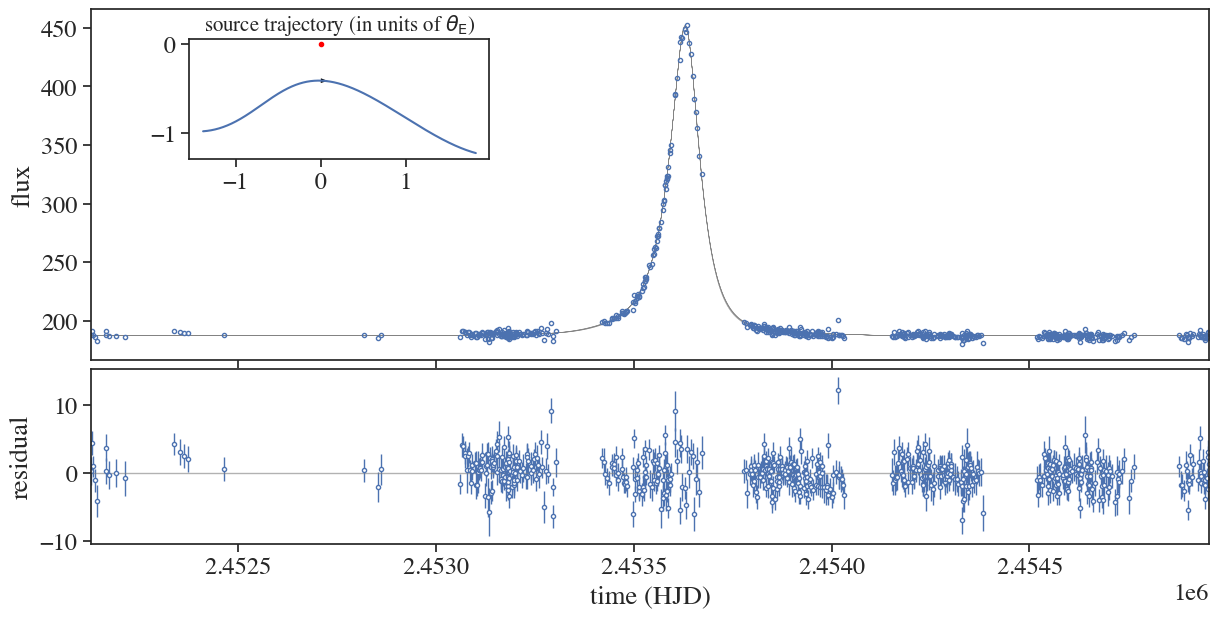

In [18]:
sample_maxlike = analyzer.get_best_fit()['parameters']

fig, (ax, ax2) = plt.subplots(2, 1, gridspec_kw={"height_ratios": [2, 1]}, sharex=True)

ax.set_ylabel("flux")
ax2.set_ylabel("residual")
ax2.set_xlabel("time (HJD)")

ax.plot(data.time, data.flux, '.', mfc='none')
ax.set_xlim(data.time[0], data.time[-1])
#ax.set_yscale("log")

model = optim.get_model(data.time, sample_maxlike, fitF=False)
ax2.errorbar(data.time, data.flux - model, yerr=data.err_flux, fmt='.', mfc='white', lw=1)
ax2.axhline(y=0, color='gray', lw=1, alpha=0.6)

t_dense = np.linspace(data.time[0], data.time[-1], 5000)
random_idx = np.random.randint(0, len(samples), 20)
models = []
for idx in random_idx:
    m = optim.get_model(t_dense, samples[idx], fitF=False)
    ax.plot(t_dense, m, '-', lw=0.1, color='gray', zorder=-1000)

axtraj = plt.axes([0.15, 0.75, 0.25, 0.2])
for (i, param) in enumerate(parameters_to_fit[:-2]):
    setattr(event.model.parameters, param, sample_maxlike[i])
event.model.plot_trajectory(caustics=True)
axtraj.set_title(r'source trajectory (in units of $\theta_\mathrm{E}$)', fontsize=15)

fig.tight_layout(pad=0.02)
plt.savefig(run_kwargs['outputfiles_basename']+"models.png", dpi=200, bbox_inches="tight")

In [19]:
# save posterior samples with parameter names
names = parameters_to_fit+["ftot", "fb_frac", "loglike"]
samples = analyzer.get_equal_weighted_posterior()
df = pd.DataFrame(samples, columns=names)
df.to_csv(run_kwargs['outputfiles_basename']+"posterior_samples.csv", index=False)